In [ ]:
!pip install pandas
!pip install openpyxl
!pip install matplotlib
!pip install tensorflow matplotlib numpy==1.24.3 
!pip install scikit-learn
!pip install scipy==1.10.1

In [1]:
import os
import pandas as pd
import numpy as np

# Folder containing Excel files
folder_path = '../dataset/'

# Initialize lists for data
X_list = []
y_list = []

In [2]:
# Load the file using openpyxl to handle messy formatting and extract content textually
from openpyxl import load_workbook

# Specify the file path
file_path = '../dataset/raw_data/LED_Matrix_2025_04_30_23_42_06.xlsx'

# Load workbook and the sheet
wb = load_workbook(file_path, data_only=True)
phys_sheet = wb['Physical_Setup']

# Read the entire column A as text (it contains all content of interest)
column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

# Find the start of the 13x15 grid (Graph Grid 13x15 (1 or 0))
grid_start_idx = -1
for i, val in enumerate(column_data):
    if "Graph Grid 13x15" in str(val):
        grid_start_idx = i + 3  # Skip header rows like "Row1:", "Column1:"
        break

# Extract 13x15 binary grid
grid_lines = column_data[grid_start_idx:grid_start_idx + 15]
grid_matrix = []
for line in grid_lines:
    digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
    if len(digits) == 13:
        grid_matrix.append(digits)

# Also extract the 5x5 occupancy mask (bottom part, after the phrase "Grid occupancy of object")
occupancy_start = -1
for i, val in enumerate(column_data):
    if "Grid occupancy of object" in str(val):
        occupancy_start = i + 1
        break

occupancy_lines = column_data[occupancy_start:occupancy_start + 5]
occupancy_matrix = []
for line in occupancy_lines:
    digits = [int(cell) for cell in str(line).strip().split() if cell.isdigit()]
    if len(digits) == 5:
        occupancy_matrix.append(digits)

import numpy as np
grid_array = np.array(grid_matrix)
occupancy_array = np.array(occupancy_matrix)

grid_array.shape, occupancy_array.shape


((14, 13), (5, 5))

In [3]:
def extract_X_y_from_excel_13x15(file_path):
    try:
        wb = load_workbook(file_path, data_only=True)

        # ---- Extract X from 'Average' ----
        avg_sheet = wb['Average']
        X = []
        for row in avg_sheet.iter_rows(min_row=2, max_row=26, min_col=2, max_col=26, values_only=True):
            X.append(list(row))
        X_array = np.array(X)
        if X_array.shape != (25, 25):
            raise ValueError(f"X shape incorrect: {X_array.shape}")

        # ---- Extract y from 'Physical_Setup' ----
        phys_sheet = wb['Physical_Setup']
        column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

        # Find grid start
        grid_start = -1
        for i, val in enumerate(column_data):
            if "Graph Grid 13x15" in str(val):
                grid_start = i + 3
                break

        # Parse up to 20 rows, pick only rows with 13 binary digits
        y = []
        for line in column_data[grid_start:grid_start + 20]:
            digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
            if len(digits) == 13:
                y.append(digits)
        y_array = np.array(y)

        # Pad to (15, 13) if needed
        while y_array.shape[0] < 15:
            y_array = np.vstack([y_array, np.zeros((1, 13), dtype=int)])

        if y_array.shape != (15, 13):
            raise ValueError(f"y shape still incorrect after padding: {y_array.shape}")

        return X_array, y_array

    except Exception as e:
        print(f"Error in file {file_path}: {e}")
        return None, None



In [4]:
X, y = extract_X_y_from_excel_13x15('input/LED_Matrix_2025_04_30_23_42_06.xlsx')

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (25, 25)
y shape: (15, 13)


In [5]:
print("X values:\n", X)
print("y values:\n", y)


X values:
 [[443.472 452.938 441.772 439.7   446.016 429.066 448.362 446.736 370.228
  455.336 447.27  455.574 449.604 452.938 447.726 452.988 460.492 463.334
  460.426 461.756 454.768 468.254 467.012 467.81  465.256]
 [445.072 428.844 429.566 423.38  440.608 432.236 438.958 430.102 434.112
  446.762 441.776 437.776 455.778 456.156 453.286 447.238 466.234 461.73
  459.768 458.712 468.694 464.328 469.72  465.472 469.506]
 [441.066 420.38  417.382 415.588 429.092 437.088 428.928 419.746 423.274
  425.    429.18  426.768 426.844 443.602 452.548 446.22  449.564 465.36
  460.882 465.966 460.352 474.844 472.468 463.352 457.14 ]
 [443.09  429.5   423.414 413.67  420.654 443.998 432.266 396.622 417.28
  424.524 439.978 423.93  430.796 442.244 455.768 452.782 438.142 449.116
  452.926 448.732 464.336 458.862 469.594 459.246 467.488]
 [458.02  442.558 441.106 439.056 446.61  455.732 443.922 440.714 440.98
  452.076 462.9   449.168 442.048 454.294 462.024 458.584 450.412 457.87
  473.2   471.33  

In [6]:
import os
import numpy as np
from openpyxl import load_workbook

def extract_X_y_from_excel_13x15(file_path):
    try:
        wb = load_workbook(file_path, data_only=True)

        # --- Extract X from 'Average' sheet ---
        avg_sheet = wb['Average']
        X = []
        for row in avg_sheet.iter_rows(min_row=2, max_row=26, min_col=2, max_col=26, values_only=True):
            X.append(list(row))
        X_array = np.array(X)
        if X_array.shape != (25, 25):
            raise ValueError(f"X shape incorrect: {X_array.shape}")

        # --- Extract y from 'Physical_Setup' ---
        phys_sheet = wb['Physical_Setup']
        column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

        grid_start = -1
        for i, val in enumerate(column_data):
            if "Graph Grid 13x15" in str(val):
                grid_start = i + 3
                break

        y = []
        for line in column_data[grid_start:grid_start + 20]:
            digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
            if len(digits) == 13:
                y.append(digits)
        y_array = np.array(y)

        # Pad y to (15, 13)
        while y_array.shape[0] < 15:
            y_array = np.vstack([y_array, np.zeros((1, 13), dtype=int)])

        if y_array.shape != (15, 13):
            raise ValueError(f"y shape still incorrect after padding: {y_array.shape}")

        return X_array, y_array

    except Exception as e:
        print(f"[ERROR] {file_path}: {e}")
        return None, None


# ---- Loop over all files in 'input/' folder ----
folder_path = 'input'
X_list = []
y_list = []

for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        path = os.path.join(folder_path, file)
        X, y = extract_X_y_from_excel_13x15(path)
        if X is not None and y is not None:
            X_list.append(X)
            y_list.append(y)

# ---- Convert to numpy arrays and save ----
X_all = np.array(X_list)
y_all = np.array(y_list)

print(f"✅ Extracted {len(X_all)} samples.")
np.savez('led_dataset_13x15.npz', X=X_all, y=y_all)


[ERROR] input\~$LED_Matrix_2025_02_24_22_52_37.xlsx: File is not a zip file
[ERROR] input\~$LED_Matrix_2025_02_24_23_24_01.xlsx: File is not a zip file
✅ Extracted 137 samples.


In [7]:
data = np.load('led_dataset_13x15.npz')
X = data['X']  # shape (n_samples, 25, 25)
y = data['y']  # shape (n_samples, 15, 13)


In [8]:
import numpy as np

# Load from previously saved .npz
data = np.load('led_dataset_13x15.npz')
X_all = data['X']  # shape: (n_samples, 25, 25)
y_all = data['y']  # shape: (n_samples, 15, 13)

# --- Step 1: Flatten ---
X_flat = X_all.reshape(len(X_all), -1)  # shape: (n_samples, 625)
y_flat = y_all.reshape(len(y_all), -1)  # shape: (n_samples, 195)

# --- Step 2: Validate ---
print("✅ Data loaded and flattened")
print("X_all shape (original):", X_all.shape)
print("y_all shape (original):", y_all.shape)
print("X_flat shape:", X_flat.shape)
print("y_flat shape:", y_flat.shape)

# Optional: check a few values
print("\nSample X[0][:10]:", X_flat[0][:10])
print("Sample y[0][:13]:", y_flat[0][:13])

# --- Step 3: Save flattened data ---
np.savez('led_dataset_flat.npz', X=X_flat, y=y_flat)
print("\n✅ Saved flattened data to 'led_dataset_flat.npz'")


✅ Data loaded and flattened
X_all shape (original): (137, 25, 25)
y_all shape (original): (137, 15, 13)
X_flat shape: (137, 625)
y_flat shape: (137, 195)

Sample X[0][:10]: [457.016 445.584 447.006 452.52  466.078 460.03  448.092 449.236 451.67
 467.728]
Sample y[0][:13]: [0 0 0 0 0 0 0 0 0 0 0 0 0]

✅ Saved flattened data to 'led_dataset_flat.npz'


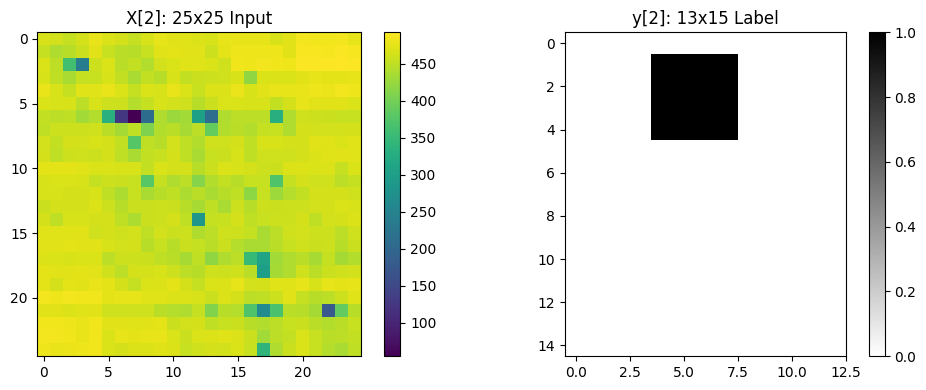

In [9]:
import matplotlib.pyplot as plt

# Show the first sample
i = 2  # or change to any index

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_all[i], cmap='viridis')
plt.title("X[{}]: 25x25 Input".format(i))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_all[i], cmap='binary')
plt.title("y[{}]: 13x15 Label".format(i))
plt.colorbar()

plt.tight_layout()
plt.show()


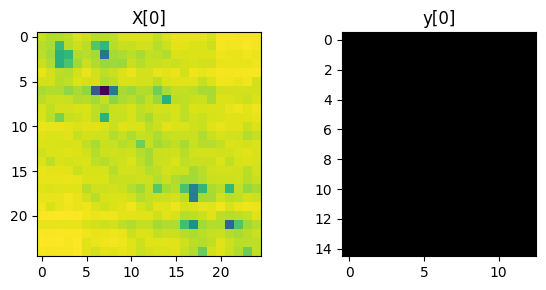

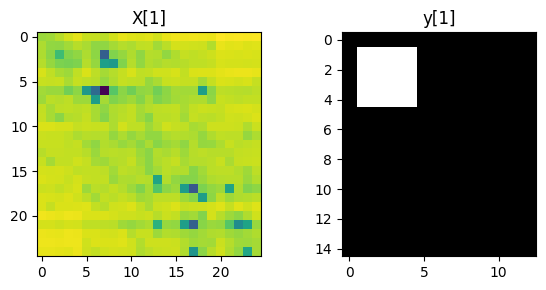

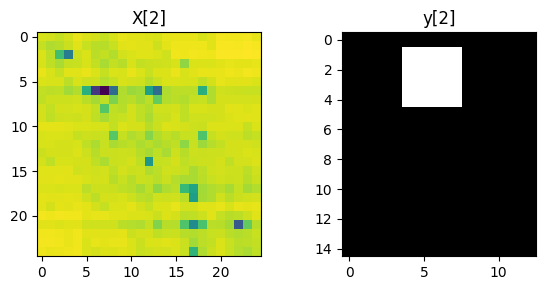

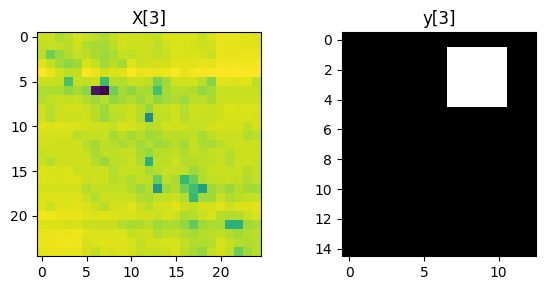

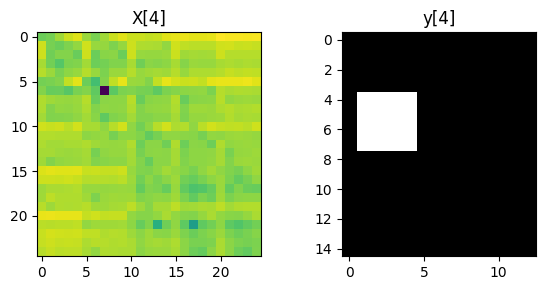

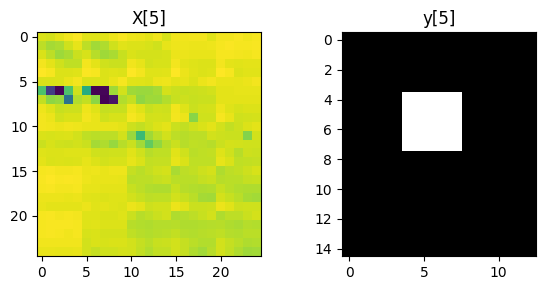

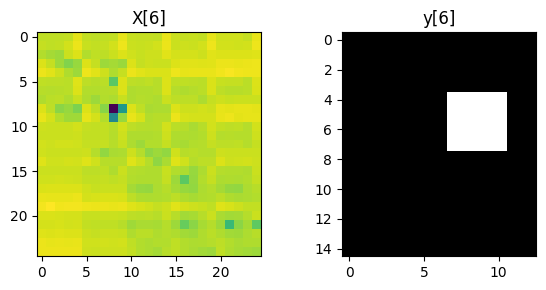

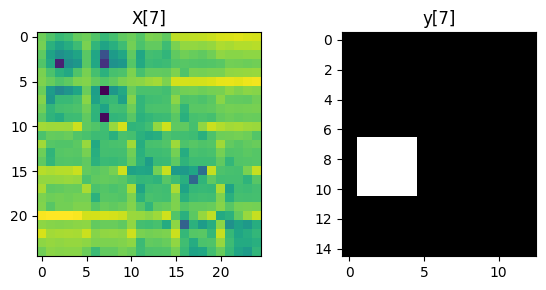

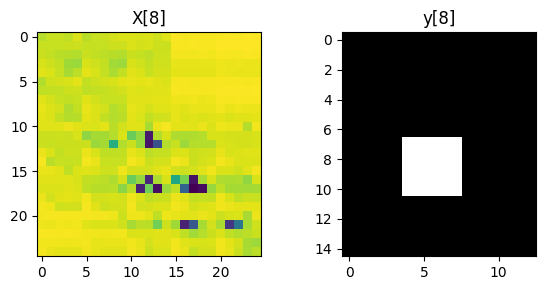

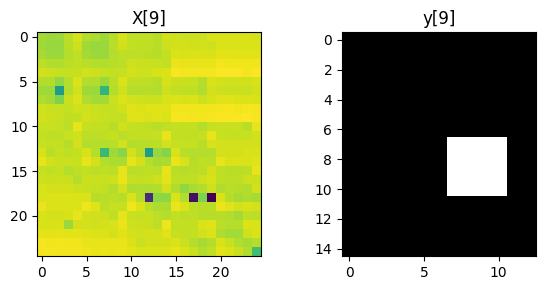

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load
data = np.load('led_dataset_13x15.npz')
X_all = data['X'][..., np.newaxis].astype('float32')  # (n, 25, 25, 1)
y_all = data['y'][..., np.newaxis].astype('float32')  # (n, 15, 13, 1)

# Normalize input
X_all /= 500.0

# Sanity check
for i in range(10):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_all[i, :, :, 0], cmap='viridis')
    plt.title("X[{}]".format(i))

    plt.subplot(1, 2, 2)
    plt.imshow(y_all[i, :, :, 0], cmap='gray')
    plt.title("y[{}]".format(i))
    plt.tight_layout()
    plt.show()


In [6]:
import tensorflow as tf

# Shuffle + split
dataset_size = X_all.shape[0]
indices = tf.random.shuffle(tf.range(dataset_size))
split = int(0.8 * dataset_size)

X_train = tf.gather(X_all, indices[:split])
X_test  = tf.gather(X_all, indices[split:])
y_train = tf.gather(y_all, indices[:split])
y_test  = tf.gather(y_all, indices[split:])

# CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25, 25, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(15 * 13, activation='sigmoid'),
    tf.keras.layers.Reshape((15, 13, 1))
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")


NameError: name 'X_all' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


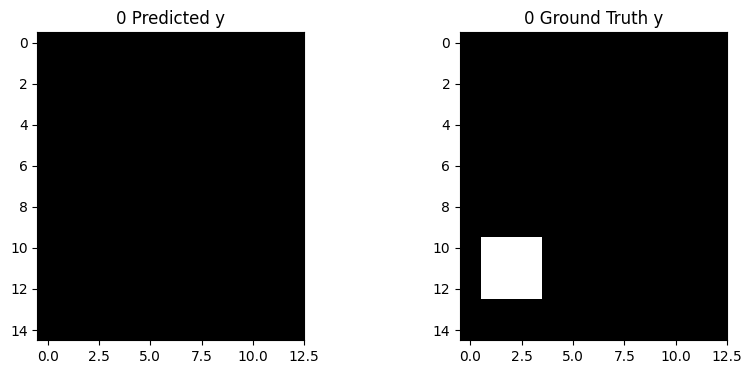

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


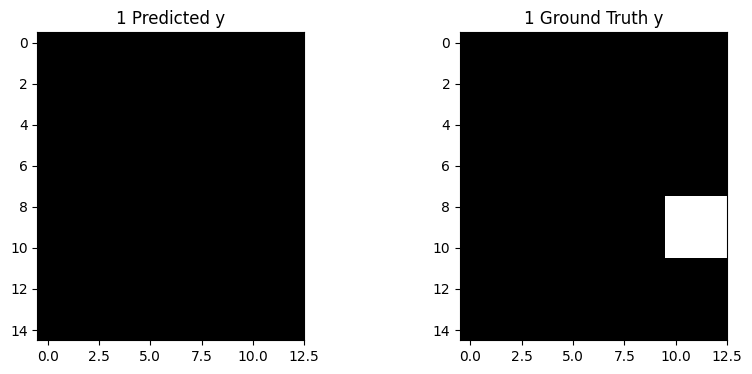

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


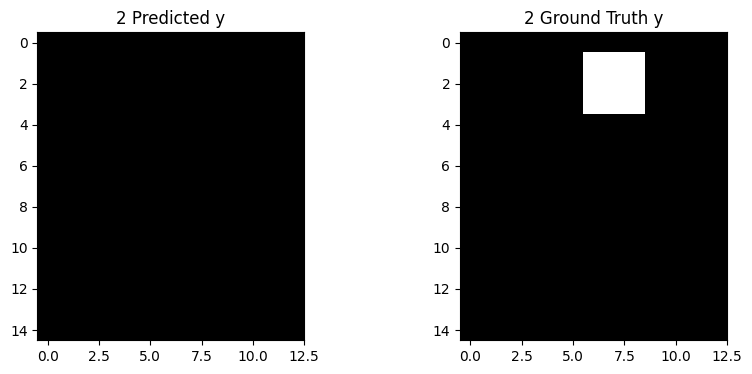

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


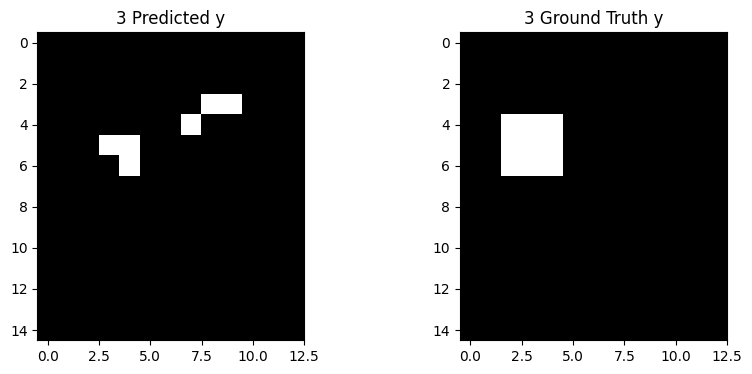

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


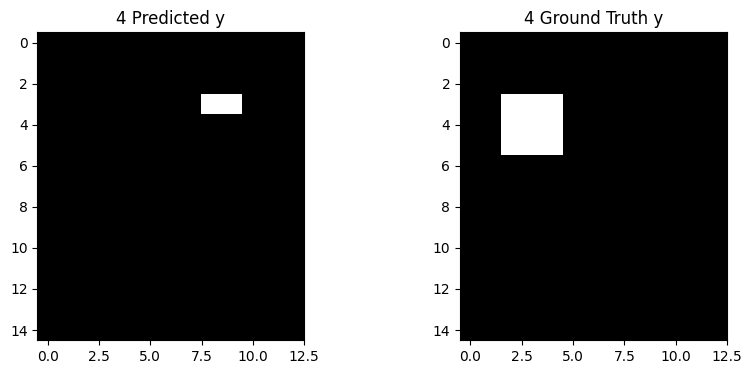

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


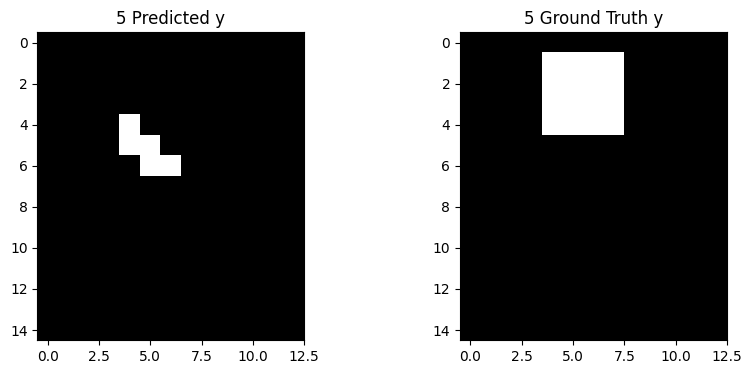

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


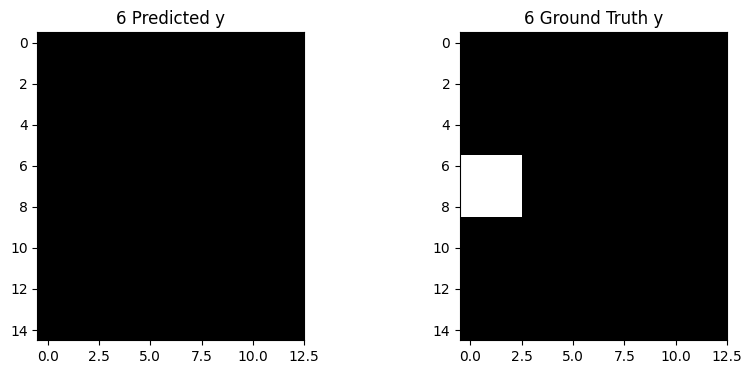

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


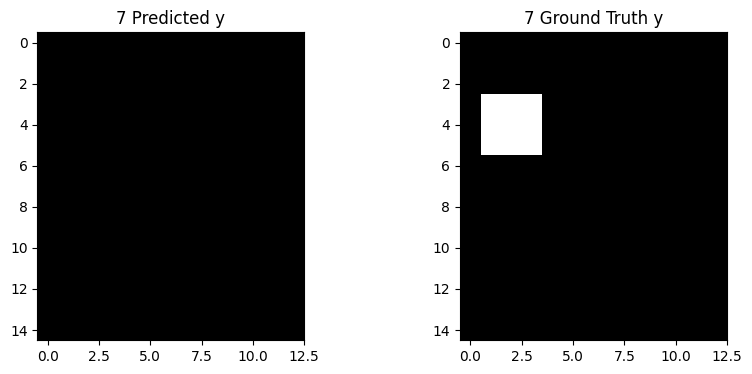

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


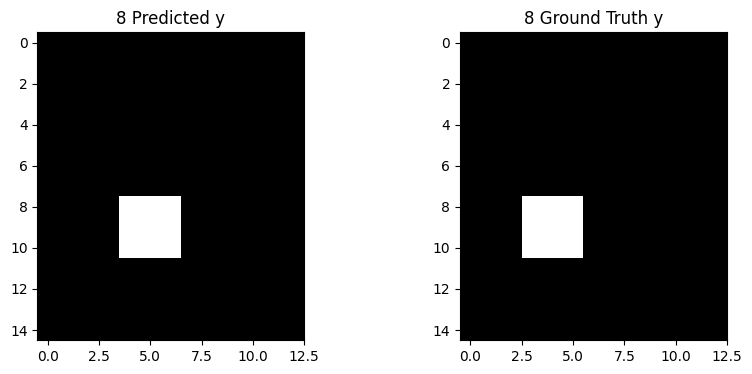

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


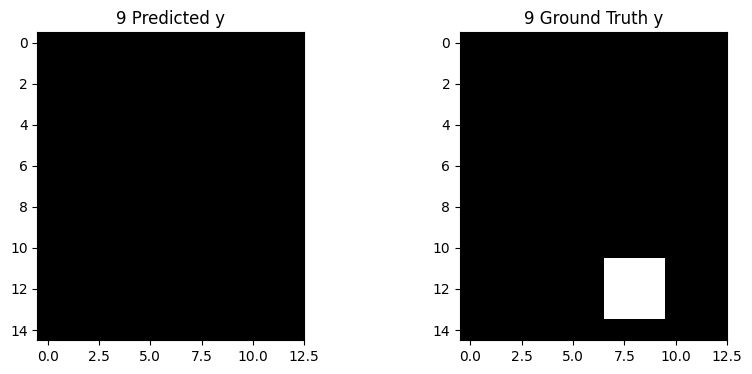

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


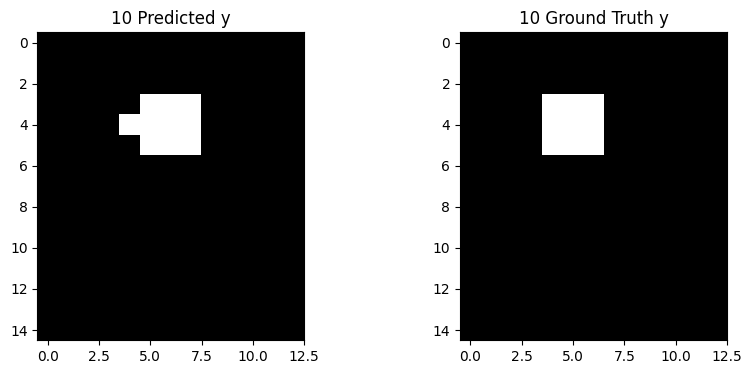

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


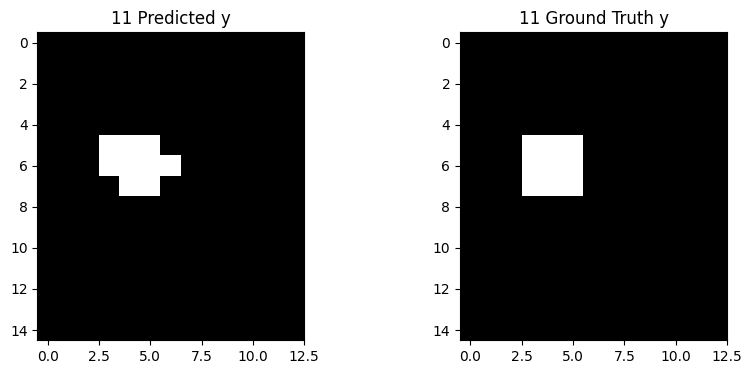

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


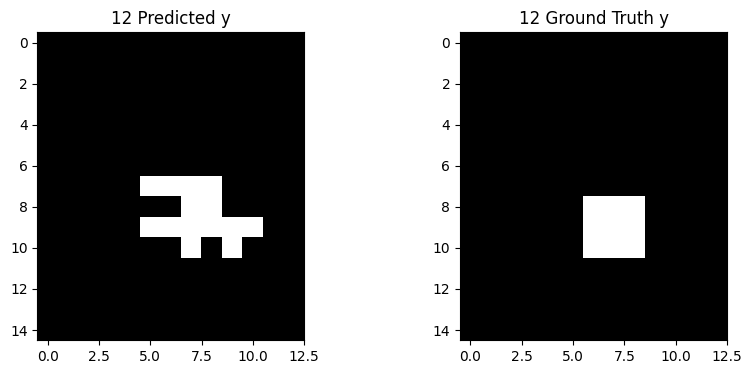

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


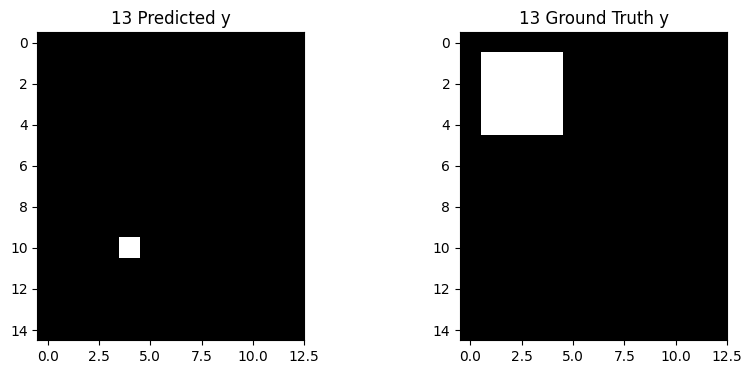

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


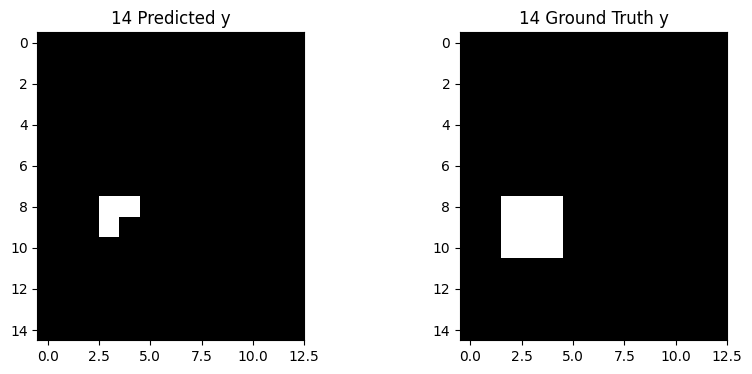

In [12]:
# Show one prediction
i = 4
for i in range (0,15):
    pred = model.predict(X_test[i:i+1])[0, ..., 0]
    true = y_test[i, ..., 0]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pred > 0.4, cmap='gray')
    plt.title(f"{i} Predicted y")
    
    plt.subplot(1, 2, 2)
    plt.imshow(true, cmap='gray')
    plt.title(f"{i} Ground Truth y")
    plt.show()


In [15]:
import numpy as np
import tensorflow as tf

# Predict on the test set
y_pred = model.predict(X_test)

# Convert to numpy arrays for easier manipulation
y_pred_np = y_pred.numpy() if tf.is_tensor(y_pred) else y_pred
y_test_np = y_test.numpy() if tf.is_tensor(y_test) else y_test

# Apply threshold to get binary predictions
y_pred_bin = (y_pred_np > 0.5).astype(np.float32)

# Reshape to 2D arrays (samples, features)
y_pred_flat = y_pred_bin.reshape(y_pred_bin.shape[0], -1)
y_test_flat = y_test_np.reshape(y_test_np.shape[0], -1)

# Check for perfect matches
correct_predictions = np.all(y_pred_flat == y_test_flat, axis=1)
num_correct = np.sum(correct_predictions)
total = y_test_flat.shape[0]

print(f"Number of perfectly predicted samples: {num_correct} out of {total}")
print(f"Perfect prediction rate: {num_correct / total:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Number of perfectly predicted samples: 0 out of 28
Perfect prediction rate: 0.00%


In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model.predict(X_test)

# Convert to numpy arrays
y_pred_np = y_pred.numpy() if tf.is_tensor(y_pred) else y_pred
y_test_np = y_test.numpy() if tf.is_tensor(y_test) else y_test

# Apply threshold
y_pred_bin = (y_pred_np > 0.5).astype(np.float32)

# Flatten for metrics
y_true_flat = y_test_np.reshape(-1)
y_pred_flat = y_pred_bin.reshape(-1)

# Calculate metrics
accuracy = np.mean(y_pred_flat == y_true_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print("Pixel-level metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate sample-wise accuracy
sample_accuracies = []
for i in range(len(y_test_np)):
    correct = np.mean((y_pred_bin[i] > 0.5) == (y_test_np[i] > 0.5))
    sample_accuracies.append(correct)

print(f"\nSample-wise average accuracy: {np.mean(sample_accuracies):.2%}")
print(f"Minimum sample accuracy: {min(sample_accuracies):.2%}")
print(f"Maximum sample accuracy: {max(sample_accuracies):.2%}")

# Check for samples with accuracy > 90%
high_acc_samples = sum(1 for acc in sample_accuracies if acc > 0.9)
print(f"\nSamples with >90% accuracy: {high_acc_samples}/{len(sample_accuracies)} ({(high_acc_samples/len(sample_accuracies)):.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pixel-level metrics:
Accuracy: 0.9529
Precision: 0.6471
Recall: 0.2300
F1 Score: 0.3393

Sample-wise average accuracy: 95.29%
Minimum sample accuracy: 91.28%
Maximum sample accuracy: 98.46%

Samples with >90% accuracy: 28/28 (100.00%)


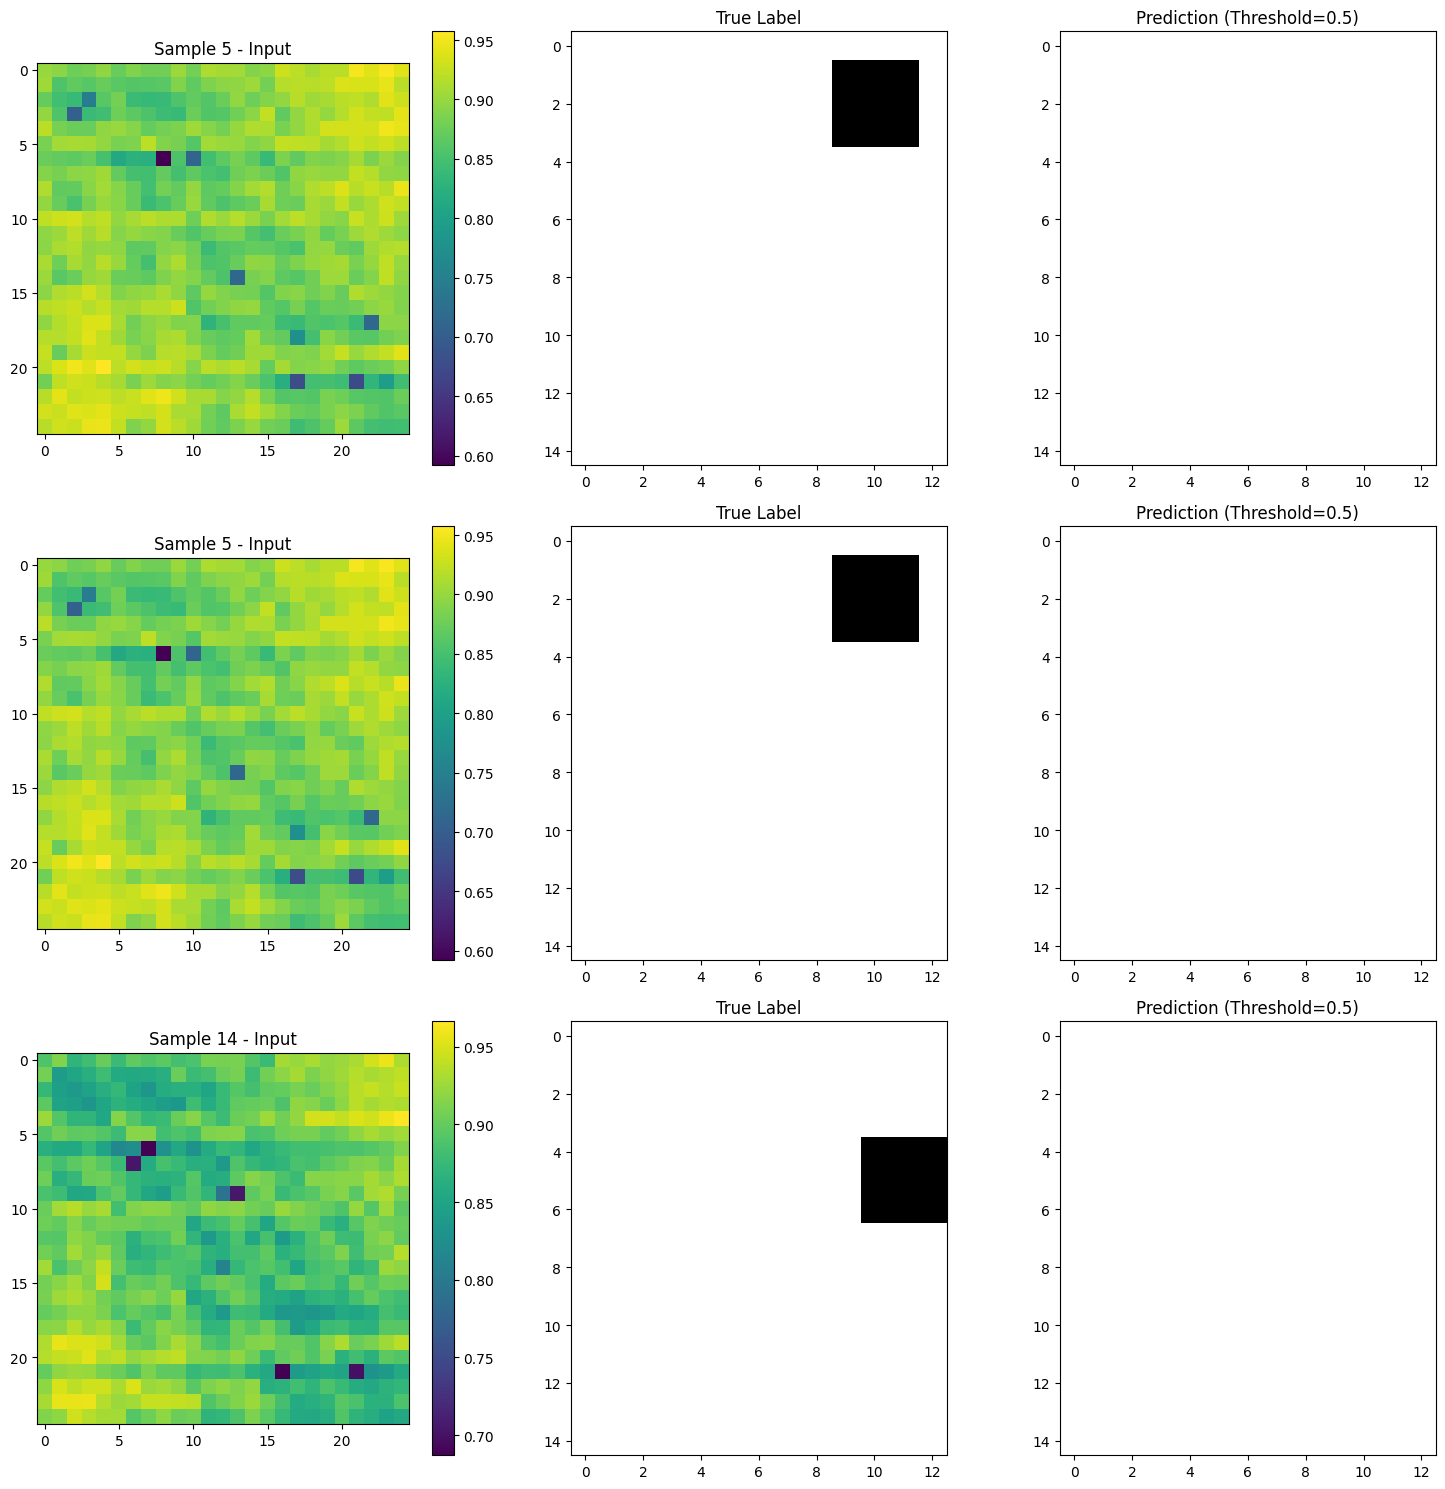

In [17]:
import matplotlib.pyplot as plt

def plot_sample_predictions(X, y_true, y_pred, num_samples=3, threshold=0.5):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        
        # Plot input
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[idx].squeeze(), cmap='viridis')
        plt.title(f'Sample {idx+1} - Input')
        plt.colorbar()
        
        # Plot true label
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title('True Label')
        
        # Plot prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((y_pred[idx] > threshold).squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title(f'Prediction (Threshold={threshold})')
        
    plt.tight_layout()
    plt.show()

# Convert tensors to numpy if needed
X_test_np = X_test.numpy() if tf.is_tensor(X_test) else X_test
y_test_np = y_test.numpy() if tf.is_tensor(y_test) else y_test

# Plot some predictions
plot_sample_predictions(X_test_np, y_test_np, y_pred)

In [18]:
def get_class_weights(y_true):
    # Flatten the labels and count class frequencies
    y_flat = y_true.reshape(-1)
    total = len(y_flat)
    class_weights = {
        0: (1 / (y_flat == 0).sum()) * (total / 2.0),
        1: (1 / (y_flat == 1).sum()) * (total / 2.0)
    }
    return class_weights

# Calculate class weights
y_train_np = y_train.numpy() if tf.is_tensor(y_train) else y_train
class_weights = get_class_weights(y_train_np)
print("Class weights:", class_weights)

# Define a new model with the same architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(25, 25, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(15 * 13, activation='sigmoid'),
        tf.keras.layers.Reshape((15, 13, 1))
    ])
    return model

# Compile with class weights
model_weighted = create_model()
model_weighted.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 
                              tf.keras.metrics.Recall(name='recall'),
                              tf.keras.metrics.Precision(name='precision')])

# Train the model with class weights
history_weighted = model_weighted.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights
)

# Evaluate the model
y_pred_weighted = model_weighted.predict(X_test)

Class weights: {0: 0.5269486314954384, 1: 9.776908923643054}


TypeError: only size-1 arrays can be converted to Python scalars

In [19]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fn

# Create and compile model with focal loss
model_focal = create_model()
model_focal.compile(optimizer='adam',
                   loss=focal_loss(),
                   metrics=['accuracy', 
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.Precision(name='precision')])

# Train the model with focal loss
history_focal = model_focal.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1
)

# Evaluate the model
y_pred_focal = model_focal.predict(X_test)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6947 - loss: 0.0968 - precision: 0.0541 - recall: 0.2884 - val_accuracy: 0.9515 - val_loss: 0.0211 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9416 - loss: 0.0328 - precision: 0.1017 - recall: 0.0165 - val_accuracy: 0.9515 - val_loss: 0.0300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9436 - loss: 0.0248 - precision: 0.1259 - recall: 0.0165 - val_accuracy: 0.9515 - val_loss: 0.0309 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9497 - loss: 0.0214 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9515 - val_loss: 0.0279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9481 - loss: 0.0209 - precision: 0.0000e+00 - recall: 0.0000e+00 - va

In [21]:
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add small epsilon to avoid division by zero
    return iou

# Calculate IoU for all models
def evaluate_model(model, X, y_true, threshold=0.5):
    y_pred = model.predict(X)
    iou = iou_metric(y_true, y_pred, threshold)
    return iou.numpy()

# Evaluate all models
print("\nEvaluating models...")
print(f"Original model IoU: {evaluate_model(model, X_test, y_test):.4f}")
print(f"Class weighted model IoU: {evaluate_model(model_weighted, X_test, y_test):.4f}")
print(f"Focal loss model IoU: {evaluate_model(model_focal, X_test, y_test):.4f}")

# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history for both models
plot_history(history_weighted, "Class Weighted Model")
plot_history(history_focal, "Focal Loss Model")


Evaluating models...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Original model IoU: 0.2043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class weighted model IoU: 0.0558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Focal loss model IoU: 0.1871


NameError: name 'history_weighted' is not defined

In [22]:
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba > thresh).astype(np.float32)
        f1 = f1_score(y_true.reshape(-1), y_pred.reshape(-1))
        f1_scores.append(f1)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, f1_scores, 'b-')
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Optimal Threshold: {best_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()
    
    return best_threshold

# Find optimal threshold for the focal loss model
y_pred_proba = model_focal.predict(X_test)
best_threshold = find_optimal_threshold(y_test, y_pred_proba)
print(f"Optimal threshold: {best_threshold:.3f}")

# Evaluate with optimal threshold
y_pred_optimal = (y_pred_focal > best_threshold).astype(np.float32)
optimal_iou = iou_metric(y_test, y_pred_optimal).numpy()
print(f"Optimal threshold IoU: {optimal_iou:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [7]:
# 1. First, import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

# 2. Define helper functions
def plot_sample_predictions(X, y_true, y_pred, num_samples=3, threshold=0.5):
    plt.figure(figsize=(15, 5*num_samples))
    
    # Convert to numpy if they're tensors
    X = X.numpy() if tf.is_tensor(X) else X
    y_true = y_true.numpy() if tf.is_tensor(y_true) else y_true
    y_pred = y_pred.numpy() if tf.is_tensor(y_pred) else y_pred
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[idx].squeeze(), cmap='viridis')
        plt.title(f'Sample {idx+1} - Input')
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title('True Label')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((y_pred[idx] > threshold).squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title(f'Prediction (Threshold={threshold})')
        
    plt.tight_layout()
    plt.show()

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(25, 25, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),  # -> 12x12
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),  # -> 6x6
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.UpSampling2D(size=2),  # -> 12x12
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        
        tf.keras.layers.UpSampling2D(size=2),  # -> 24x24
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        
        tf.keras.layers.ZeroPadding2D(padding=((1, 0), (1, 0))),  # Pad to 25x25
        tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')
    ])
    return model


def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fn

def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def evaluate_model(model, X, y_true, threshold=0.5):
    y_pred = model.predict(X)
    iou = iou_metric(y_true, y_pred, threshold)
    return iou.numpy()

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def find_optimal_threshold(y_true, y_pred_proba):
    # Ensure inputs are numpy arrays
    y_true_np = y_true.numpy() if tf.is_tensor(y_true) else y_true
    y_pred_proba_np = y_pred_proba.numpy() if tf.is_tensor(y_pred_proba) else y_pred_proba
    
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba_np > thresh).astype(np.float32)
        f1 = f1_score(y_true_np.reshape(-1), y_pred.reshape(-1))
        f1_scores.append(f1)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, f1_scores, 'b-')
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Optimal Threshold: {best_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()
    
    return best_threshold

# 3. Ensure all data is in numpy format
X_train_np = X_train.numpy() if tf.is_tensor(X_train) else X_train
y_train_np = y_train.numpy() if tf.is_tensor(y_train) else y_train
X_test_np = X_test.numpy() if tf.is_tensor(X_test) else X_test
y_test_np = y_test.numpy() if tf.is_tensor(y_test) else y_test

# 4. Visualize some predictions from the original model
print("Visualizing some predictions from the original model:")
y_pred_original = model.predict(X_test_np)
plot_sample_predictions(X_test_np, y_test_np, y_pred_original)

# 5. Train and evaluate focal loss model
print("\nTraining focal loss model...")
model_focal = create_model()
model_focal.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=['accuracy', 
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision')]
)

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Convert data to float32 to avoid any type issues
X_train_float = X_train_np.astype('float32')
y_train_float = y_train_np.astype('float32')

history_focal = model_focal.fit(
    X_train_float, y_train_float,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping]
)

# 6. Plot training history
print("\nPlotting training history...")
plot_history(history_focal, "Focal Loss Model")

# 7. Find optimal threshold
print("\nFinding optimal threshold...")
y_pred_proba = model_focal.predict(X_test_np)
best_threshold = find_optimal_threshold(y_test_np, y_pred_proba)
print(f"Optimal threshold: {best_threshold:.3f}")

# 8. Visualize predictions with optimal threshold
print("\nVisualizing predictions with optimal threshold...")
plot_sample_predictions(X_test_np, y_test_np, y_pred_proba, threshold=best_threshold)

# 9. Calculate and print final metrics
y_pred_optimal = (y_pred_proba > best_threshold).astype(np.float32)
optimal_iou = iou_metric(y_test_np, y_pred_optimal, best_threshold).numpy()

y_true_flat = y_test_np.reshape(-1)
y_pred_flat = y_pred_optimal.reshape(-1)

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print("\nFinal Metrics with Optimal Threshold:")
print(f"IoU: {optimal_iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 10. Calculate and print per-sample accuracy
sample_accuracies = []
for i in range(len(y_test_np)):
    correct = np.mean((y_pred_proba[i] > best_threshold) == (y_test_np[i] > 0.5))
    sample_accuracies.append(correct)

print(f"\nSample-wise accuracy with optimal threshold:")
print(f"Average: {np.mean(sample_accuracies):.2%}")
print(f"Minimum: {min(sample_accuracies):.2%}")
print(f"Maximum: {max(sample_accuracies):.2%}")

NameError: name 'X_train' is not defined